## IRFX Computer Assignment
Zhilin Liu $ \ \ $ N15584048 $\ \ \$ Spring 2020

In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### SABR model:

$$\sigma^{IV}(K,t) \approx \frac{\alpha_0}{(FK)^{\frac{1-\beta}{2}}
\left\{1+\frac{(1-\beta)^2}{24}\log^2{\frac{F}{K}}+\frac{(1-\beta)^4}{1920}\log^4{\frac{F}{K}}\right\}\\
\cdot(\frac{z}{x(z)})\cdot\left\{1+[\frac{(1-\beta)^2}{24}\frac{\alpha^2}{(FK)^{1-\beta}}
+\frac{1}{4}\frac{\rho\beta\nu\alpha}{(FK)^{\frac{1-\beta}{2}}}+\frac{2-\beta\rho^2}{24}\nu^2]t\right\}}$$

where
$$\hat{\alpha}(0) = \alpha$$
$$z=\frac{\nu}{\alpha}(FK)^{\frac{1-\beta}{2}}\log{\frac{F}{K}}$$
$$x(z)=\log{(\frac{\sqrt{1-2\rho z+z^2}+z-\rho}{1-\rho})}$$


In [2]:
rd = 6.5/100
rf = 2.2/100
S = 3.724
delta = 25/100
b = 1


def IV_SABR(S, K, a, b, r, v, rd, rf, T):
    """
    Implied vol approximation by SABR
    
    S: spot rate
    K: strike
    a: alpha = intial level of alpha_hat
    b: beta = 1
    r: pho
    v: vol of vol 
    rd: domestic int rate     BRL
    rf: foregin int rate      USD
    T: time to maturity in yr
    """
    r = abs(r)%2
    F = S * np.exp((rd-rf)*T)
    K = abs(K)
    z = v* ((F*K)**((1-b)/2))*np.log(F/K)/a
    x = np.log(((1-2*r*z+z**2)**0.5+z-r)/(1-r))
    part1 = a/( ((F*K)**((1-b)/2)) * (1 + (((1-b)**2) * (np.log(F/K))**2 / 24) + (((1-b)**4) * (np.log(F/K))**4 / 1920)))
    part2 = z/x
    part3 = 1 + ( ((1-b)**2)*(a**2)/24/((F*K)**(1-b)) + r*b*v*a/4/((F*K)**((1-b)/2)) + (2-3*(r**2))*(v**2)/24 )*T
    return part1*part2*part3
    

#### Black-Scholes pricing:

In [3]:
def Call_BS(S, K, T, rd, rf, sigma):
    """
    BS Spot pricing formula for Vanilla Call Option
    
    S: Spot rate
    K: strike
    T: time to maturity
    rd: domestic int rate     BRL
    rf: foregin int rate      USD
    sigma: volatility
    """
    F = S * np.exp((rd-rf)*T)
    
    d1 = np.log(F/K)/sigma/np.sqrt(T) + sigma*np.sqrt(T)/2
    d2 = np.log(F/K)/sigma/np.sqrt(T) - sigma*np.sqrt(T)/2
    
    return np.exp(-rd*T)*(F*norm.cdf(d1) - K * norm.cdf(d2))

def Put_BS(S,K,T,rd,rf,sigma):
    """
    BS Spot pricing formula for Vanilla Put Option
    
    S: Spot rate
    K: strike
    T: time to maturity
    rd: domestic int rate     BRL
    rf: foregin int rate      USD
    sigma: volatility
    """
    F = S * np.exp((rd-rf)*T)
    
    d1 = np.log(F/K)/sigma/np.sqrt(T) + sigma*np.sqrt(T)/2
    d2 = np.log(F/K)/sigma/np.sqrt(T) - sigma*np.sqrt(T)/2
    
    return -np.exp(-rd*T)*(F*norm.cdf(-d1) - K * norm.cdf(-d2))

#### Solve for Strike ATM: 
* Delta-neutral-straddle
* Premium-included delta
$$K_{ATM} = e^{-\frac{1}{2}\sigma^2T}F$$

In [4]:
def solveFor_K_ATM(S,T,rd,rf,sigma):
    """
    obtain at-the-money DNS strike from given market data ATM vol 
    
    S: spot rate
    T: maturity
    rd: domestic int rate     BRL
    rf: foregin int rate      USD
    sigma: given mkt data -> ATM vol
    """
    F = S * np.exp((rd-rf)*T)
    return np.exp(-(sigma**2)*T/2) * F

#### Obtain Delta for Call & Put:
Premium-included Spot Delta:

$$\Delta_C = e^{-r_fT}\frac{K}{F}N(d_2)$$
$$\Delta_P = -e^{-r_fT}\frac{K}{F}N(-d_2)$$

In [5]:
def delta_C(S,K,T,rd,rf,sigma):
    """
    premium-included SPOT call delta for vol sigma, strike K
    
    S: spot rate
    K: strike
    T: maturity
    rd: domestic int rate     BRL
    rf: foregin int rate      USD
    sigma: vol
    """
    F = S * np.exp((rd-rf)*T)
    d2 = np.log(F/K)/sigma/np.sqrt(T) - sigma*np.sqrt(T)/2
    
    return np.exp(-rf*T)*K*norm.cdf(d2)/F


def delta_P(S,K,T,rd,rf,sigma):
    """
    premium-included SPOT put delta for vol sigma, strike K
    
    S: spot rate
    K: strike
    T: maturity
    rd: domestic int rate     BRL
    rf: foregin int rate      USD
    sigma: vol
    """
    F = S * np.exp((rd-rf)*T)
    d2 = np.log(F/K)/sigma/np.sqrt(T) - sigma*np.sqrt(T)/2
    
    return -np.exp(-rf*T)*K*norm.cdf(-d2)/F

#### Given Delta, Solve for Strikes:
According to the paper given by prof., on ***page 10-11***, apply ```Brent``` root finder here.
* Kmax is the premium-excluded forward delta strike:
$$ K = Fe^{-iN^{-1}(i\triangle_f)\sigma\sqrt t+\frac{1}{2}\sigma^2t} \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ (16)$$
where $i = 1$ for call, $-1$ for put.
* Kmin is solved from, on page 11:
$$\sigma \sqrt{t} N(d_{\_}) = n(d_{\_})$$
* Given additional resource: FX Volatility Smile Construction, Reiswich and Wystup, 2009. https://mathfinance.com/wp-content/uploads/2017/06/CPQF_Arbeits20_neu2.pdf

In [6]:
# use Brent to solve for K_BF, according to paper provided by prof
def Kmax(S,T,rd,rf,sigma,i):
    """
    premium excluded forward delta K
    i = 1 for call, -1 for put
    """
    F = S * np.exp((rd-rf)*T)
    return F*np.exp(-i*sigma*np.sqrt(T)*norm.pdf(i*np.exp(rf*T)*0.25)+T*sigma**2/2)

def Kmin(S,T,rd,rf,sigma,x0):
    """
    solve Kmin from paper explained as above
    x0: initial guess for Kmin
    """
    K = x0
    F = S * np.exp((rd-rf)*T)
    def func(K):
        d2 = np.log(F/K)/sigma/np.sqrt(T) - sigma*np.sqrt(T)/2
        return sigma*np.sqrt(T)*norm.cdf(d2) - norm.pdf(d2)
    res = optimize.minimize(func, x0)
    return res.x
###################################################################


def solveFor_K_BFC(S,T,rd,rf,ATM,BF):
    sigma = ATM+BF
    Kmax1 = Kmax(S,T,rd,rf,sigma,1)
    Kmin1 = Kmin(S,T,rd,rf,sigma,S)
    def delta_BF_C(K_BFC):
        return np.abs(delta_C(S,K_BFC,T,rd,rf,sigma) -0.25)
    res = optimize.brent(delta_BF_C, brack=(Kmin1,Kmax1))

def solveFor_K_BFP(S,T,rd,rf,ATM,BF):
    sigma = ATM+BF
    Kmax2 = Kmax(S,T,rd,rf,sigma,-1)
    Kmin2 = Kmin(S,T,rd,rf,sigma,S)
    def delta_BF_P(K_BFP):
        return np.abs(delta_P(S,K_BFP,T,rd,rf,sigma) +0.25)
    res1 = optimize.brent(delta_BF_P, brack=(Kmin2,Kmax2))
    return res1[0]

#### Initial Guesses:

In [7]:
a0 = 0.111541
r0 = 0.11564
v0 = 1.75091
K_RRC0 = 4.45962
K_RRP0 = 3.45895

#alternative initial guess
X0 = [a0,r0,v0,K_RRC0,K_RRP0]
X1 = [0.2,0.5,2,S,S]
X2 = [0.2,0.5,5,4.5,3.5]
initials = [X0,X1,X2]

#### Main Calibration & Output Function:
* Using Market Convention
$$K_{BFPut} = K_P(ATM + BF,\delta)$$
$$K_{BFCall} = K_C(ATM + BF,\delta)$$
$$P^{mkt}(K_{BFPut}) + C^{mkt}(K_{BFCall}) = P^{BS}(ATM + BF,K_{BFPut}) + C^{BS}(ATM + BF,K_{BFCall})$$
$$IV (K_{RRCall} ) - IV (K_{RRPut}) = RR$$
$$\triangle_C (IV(K_{RRCall}),K_{RRCall} ) = \delta$$
$$\triangle_P(IV(K_{RRPut}),K_{RRPut})=  \delta$$
* 5 five unknowns: $\alpha,\rho,\nu,K_{RRCall},K_{RRPut}$
* 5 conditions:
$$\sigma(K_{ATM}) = ATM$$
$$\sigma(K_{RRCall} ) - \sigma(K_{RRPut}) = RR$$
$$\delta(K_{RRCall} ) = 0.25$$
$$\delta(K_{RRPut}) = -0.25$$
$$P^{model} (K_{BFPut}) + C^{model} (K_{BFCall} ) = P^{BS}(ATM + BF,K_{BFPut}) + C^{BS}(ATM + BF,K_{BFCall} )$$

In [8]:
def withinput_run(y,initial):
    
# model:
    T, ATM, RR, BF= y[0],y[1],y[2],y[3]
    K_ATM = solveFor_K_ATM(S,T,rd,rf,ATM)
    K_BFC = solveFor_K_BFC(S,T,rd,rf,ATM,BF)
    K_BFP = solveFor_K_BFP(S,T,rd,rf,ATM,BF)
    
    def SABR_Calibration(x):
        # 5 unknowns
        a,r,v,K_RRC_, K_RRP_= x[0],x[1],x[2],x[3],x[4]
        # 5 equations to satisfy
        f = [IV_SABR(S, K_ATM, a, b, r, v, rd, rf, T) - ATM,
             IV_SABR(S, K_RRC_, a, b, r, v, rd, rf, T) - IV_SABR(S, K_RRP_, a, b, r, v, rd, rf, T) - RR,
             delta_C(S, K_RRC_, T, rd, rf, IV_SABR(S, K_RRC_, a, b, r, v, rd, rf, T)) - 0.25,
             delta_P(S, K_RRP_, T, rd, rf, IV_SABR(S, K_RRP_, a, b, r, v, rd, rf, T)) + 0.25, 
             Call_BS(S, K_BFC, T, rd, rf, ATM+BF) + Put_BS(S, K_BFP, T, rd, rf, ATM+BF) 
             - Call_BS(S, K_BFC, T, rd, rf, IV_SABR(S, K_BFC, a, b, r, v, rd, rf, T)) 
             - Put_BS(S, K_BFP,T,rd,rf,IV_SABR(S, K_BFP, a, b, r, v, rd, rf, T))]
        return f
    
    #sol = optimize.root(SABR_Calibration, X0, method='hybr')#############################
    sol = optimize.least_squares(SABR_Calibration, initial,bounds=([0,-1,0,0,0],[np.inf,1,np.inf,np.inf,np.inf]))
    
    A = sol.x[0]
    R = sol.x[1]
    V = sol.x[2]
    K_RRC = sol.x[3]
    K_RRP = sol.x[4]
    
    print("a = ",A)
    print("r = ",R)
    print("v = ",V)
    print("K_ATM = ", K_ATM)
    print("Vol_ATM = ",IV_SABR(S, K_ATM, A, b, R, V, rd, rf, T))
    print("K_RRC = ",K_RRC)
    print("Vol_RRC = ",IV_SABR(S, K_RRC, A, b, R, V, rd, rf, T))
    print("K_RRP = ",K_RRP)
    print("Vol_RRP = ",IV_SABR(S, K_RRP, A, b, R, V, rd, rf, T))
    print("K_BFC = ", K_BFC)
    print("Vol_BFC = ",IV_SABR(S, K_BFC, A, b, R, V, rd, rf, T))
    print("K_BFP = ", K_BFP)
    print("Vol_BFP = ",IV_SABR(S, K_BFP, A, b, R, V, rd, rf, T))
    
    
    
# part two: delta 10 options
    def delta10_Call(K_10call):
        f = np.abs(delta_C(S,K_10call,T,rd,rf,IV_SABR(S, K_10call, A, b, R, V, rd, rf, T)) -0.10)
        return f
    K_d10_C = optimize.fsolve(delta10_Call,S)[0]
    print("K_10call = ", K_d10_C)
    
    def delta10_Put(K_10put):
        f = np.abs(delta_P(S,K_10put,T,rd,rf,IV_SABR(S, K_10put, A, b, R, V, rd, rf, T)) +0.10)
        return f
    K_d10_P = optimize.fsolve(delta10_Put,S)[0]
    print("K_10put = ", K_d10_P)
    
    # Graph：
    Strikes = np.arange(K_d10_P, K_d10_C, 0.001)  #Strikes = np.arange(2, 5, 0.001)
    IVs = []
    for k in Strikes:
        IVs.append(IV_SABR(S, k, A, b, R, V, rd, rf, T))
    plt.plot(Strikes,IVs)
    

#### Market Data Import:

In [9]:
T_1Y = 1
ATM_1Y = 13.94/100
RR_1Y = 2.9/100
BF_1Y = 0.55/100
md_Sample =  [T_1Y,ATM_1Y,RR_1Y,BF_1Y]   

T_ON = 1/365
ATM_ON = 20.98/100
RR_ON = 1.2/100
BF_ON = 0.15/100
md_ON =  [T_ON,ATM_ON,RR_ON,BF_ON]   

T_1W = 7/365
ATM_1W = 13.91/100
RR_1W = 1.3/100
BF_1W = 0.20/100
md_1W =  [T_1W,ATM_1W,RR_1W,BF_1W]   

T_2W = 14/365
ATM_2W = 13.75/100
RR_2W = 1.4/100
BF_2W = 0.20/100
md_2W =  [T_2W,ATM_2W,RR_2W,BF_2W] 

T_1M = 1/12
ATM_1M = 14.24/100
RR_1M = 1.5/100
BF_1M = 0.22/100
md_1M =  [T_1M,ATM_1M,RR_1M,BF_1M]   

T_2M = 2/12
ATM_2M = 13.84/100
RR_2M = 1.75/100
BF_2M = 0.27/100
md_2M =  [T_2M,ATM_2M,RR_2M,BF_2M]   

T_3M = 3/12
ATM_3M = 13.82/100
RR_3M = 2.0/100
BF_3M = 0.32/100
md_3M =  [T_3M,ATM_3M,RR_3M,BF_3M]  

T_6M = 6/12
ATM_6M = 13.82/100
RR_6M = 2.4/100
BF_6M = 0.43/100
md_6M =  [T_6M,ATM_6M,RR_6M,BF_6M]   

Tenors = ['ON', '1W', '2W', '1M', '2M', '3M', '6M', '1Y']
md = [md_ON,md_1W,md_2W,md_1M,md_2M,md_3M,md_6M,md_Sample]

#### Run Calibration:

-------T = ON --------
a =  0.20831557395667769
r =  0.27042619093244685
v =  5.922762630696932
K_ATM =  3.7242141818672585
Vol_ATM =  0.20980000001530202
K_RRC =  3.7531478482386884
Vol_RRC =  0.21740659776032156
K_RRP =  3.6975429506484083
Vol_RRP =  0.20540659776174783
K_BFC =  3.7523380722617086
Vol_BFC =  0.21716032172345065
K_BFP =  3.696774574771882
Vol_BFP =  0.20532274129429484
K_10call =  3.7817197986644424
K_10put =  3.6739205154084003
 
 

-------T = 1W --------
a =  0.1372349003445572
r =  0.310110395969163
v =  3.1551768304406744
K_ATM =  3.726380847347726
Vol_ATM =  0.1391000000000304
K_RRC =  3.7788959172202614
Vol_RRC =  0.14777758719326253
K_RRP =  3.680509114441346
Vol_RRP =  0.1347775871932626
K_BFC =  3.7765367878871396
Vol_BFC =  0.14732551247306896
K_BFP =  3.6783412468973222
Vol_BFP =  0.13466680925599864
K_10call =  3.834491038394036
K_10put =  3.63965929218886
 
 

-------T = 2W --------
a =  0.13572093650576622
r =  0.33835193451759454
v =  2.228121675972382


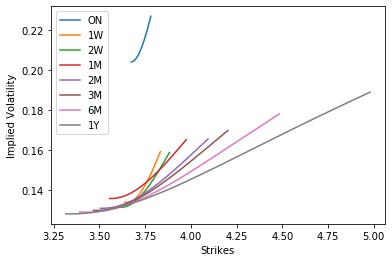

In [10]:
i = 0
for y in md:
    print("-------T =",Tenors[i],"--------")
    withinput_run(y,X2)
    print(" \n \n")
    i+=1
plt.legend(Tenors)
plt.xlabel("Strikes")
plt.ylabel("Implied Volatility")
plt.show()

#### Appendix: try different initial guesses:


 

&  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  
-------T = ON --------
a =  0.20968250610069528
r =  0.0643376460282261
v =  1.7035383497752847
K_ATM =  3.7242141818672585
Vol_ATM =  0.20982057458778347
K_RRC =  4.238044587825492
Vol_RRC =  0.24557002957026092
K_RRP =  3.2867892557089426
Vol_RRP =  0.23357032437471312
K_BFC =  3.7523380722617086
Vol_BFC =  0.21036013492750422
K_BFP =  3.696774574771882
Vol_BFP =  0.20954302775357866
K_10call =  3.777647697886888
K_10put =  3.6725656503836674
 
 
-------T = 1W --------
a =  0.13723490034550817
r =  -0.31011039599986545
v =  3.1551768301234824
K_ATM =  3.726380847347726
Vol_ATM =  0.13910000000054545
K_RRC =  3.7788959172202956
Vol_RRC =  0.14777758719334844
K_RRP =  3.6805091144413162
Vol_RRP =  0.13477758719338137
K_BFC =  3.7765367878871396
Vol_BFC =  0.14732551247318354
K_BFP =  3.6783412468973222
Vol_BFP =  0.134666809256078
K_10call =  3.8344910383932533
K_10put =  3.6396592921894726
 
 
-------T = 2W --------
a = 

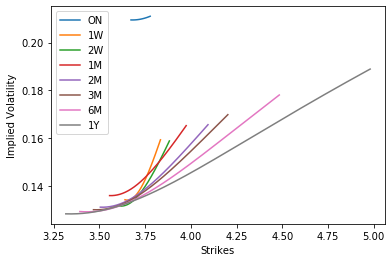


 

&  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  
-------T = ON --------
a =  0.20831557393178418
r =  0.2704261890404101
v =  5.922762670835052
K_ATM =  3.7242141818672585
Vol_ATM =  0.20980000001290808
K_RRC =  3.7531478482412086
Vol_RRC =  0.21740659777896942
K_RRP =  3.697542950645931
Vol_RRP =  0.20540659778120818
K_BFC =  3.7523380722617086
Vol_BFC =  0.217160321740247
K_BFP =  3.696774574771882
Vol_BFP =  0.20532274131531203
K_10call =  3.781719798684052
K_10put =  3.6739205153900065
 
 
-------T = 1W --------
a =  0.1372349005430443
r =  0.31011040807714413
v =  3.1551767107637674
K_ATM =  3.726380847347726
Vol_ATM =  0.1391000000351999
K_RRC =  3.778895917173796
Vol_RRC =  0.1477775870624996
K_RRP =  3.6805091144877857
Vol_RRP =  0.13477758706862952
K_BFC =  3.7765367878871396
Vol_BFC =  0.1473255123639235
K_BFP =  3.6783412468973222
Vol_BFP =  0.13466680911316012
K_10call =  3.834491037984535
K_10put =  3.639659292534782
 
 
-------T = 2W --------
a =  0.135720

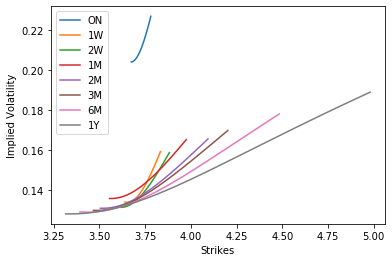


 

&  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  
-------T = ON --------
a =  0.20831557395667769
r =  0.27042619093244685
v =  5.922762630696932
K_ATM =  3.7242141818672585
Vol_ATM =  0.20980000001530202
K_RRC =  3.7531478482386884
Vol_RRC =  0.21740659776032156
K_RRP =  3.6975429506484083
Vol_RRP =  0.20540659776174783
K_BFC =  3.7523380722617086
Vol_BFC =  0.21716032172345065
K_BFP =  3.696774574771882
Vol_BFP =  0.20532274129429484
K_10call =  3.7817197986644424
K_10put =  3.6739205154084003
 
 
-------T = 1W --------
a =  0.1372349003445572
r =  0.310110395969163
v =  3.1551768304406744
K_ATM =  3.726380847347726
Vol_ATM =  0.1391000000000304
K_RRC =  3.7788959172202614
Vol_RRC =  0.14777758719326253
K_RRP =  3.680509114441346
Vol_RRP =  0.1347775871932626
K_BFC =  3.7765367878871396
Vol_BFC =  0.14732551247306896
K_BFP =  3.6783412468973222
Vol_BFP =  0.13466680925599864
K_10call =  3.834491038394036
K_10put =  3.63965929218886
 
 
-------T = 2W --------
a =  0.135

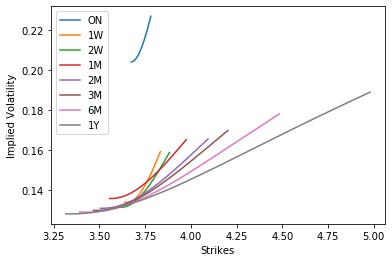

In [11]:
for initial in initials:
    print("\n \n")
    print("&  "*20)
    i = 0
    for y in md:
        print("-------T =",Tenors[i],"--------")
        withinput_run(y,initial)
        print(" \n ")
        i+=1

    plt.legend(Tenors)
    plt.xlabel("Strikes")
    plt.ylabel("Implied Volatility")
    plt.show()
    